# Navnet 3 Monocular Depth Net Test

Learn depth representations and compare discrepencies in transformation of left image to right given the depth map and the transformations between the cameras. Based on Unsupervised CNN for single View Depth Estimattion.

In [232]:
import utils
import torch
import numpy as np
import matplotlib.pyplot as plt

train_path = "/home/michael/Desktop/BytesDB_train/"
test_path = "/home/michael/Desktop/BytesDB_test/"

## Using Pandas for Dataloading and Management, New Data Management Class

In [233]:
train_data =  utils.BytesDataset(train_path, crop=0)
test_data  =  utils.BytesDataset(test_path, crop=0)

## Batch Handling

In [234]:
import random

# returns right mask, right image, left mask, left image, path

def batch_generator(dataset, image_shape=(3, 180, 320), batch_size=16):
    while True:
        
        # create memory for training data
        
        left_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        right_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        
        i = 0
        while i < batch_size:
            
            rand_source = random.randint(0, len(dataset.data)-1)
            if dataset.index_exists(rand_source):
                left_images[i] = dataset.read_torch_image(rand_source)
                right_images[i] = dataset.read_torch_image(rand_source, right=True)
                
                i += 1
        yield right_images, left_images

In [235]:
right_images, left_images = next(batch_generator(train_data))

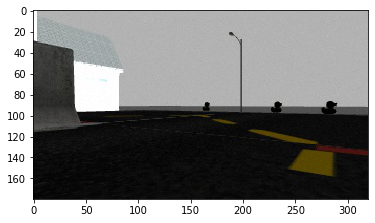

In [236]:
plt.imshow(utils.torch_image_to_cv_image(right_images[0].detach()))

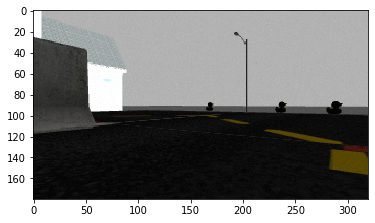

In [237]:
plt.imshow(utils.torch_image_to_cv_image(left_images[0].detach()))

## Create the autoencoder model

In [269]:
import torch.nn as nn
import torch.nn.functional as F

def same_padding(stride, width, height, filter_size):
    pad_w = ((stride-1)*width-stride+filter_size)/2
    pad_h = ((stride-1)*height-stride+filter_size)/2
    return (int(pad_h),int(pad_w))

class NavNet(nn.Module):
    def __init__(self, input_shape=(3, 90, 320)):
        super(NavNet, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        
        self.decoder = torch.nn.Sequential(
            nn.UpsamplingNearest2d((input_shape[1]//4, input_shape[2]//4)),
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.UpsamplingNearest2d((input_shape[1]//2, input_shape[2]//2)),
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.UpsamplingNearest2d((input_shape[1], input_shape[2])),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            # output has two channels. channel 1 = left disp, channel 2 = right disp
            nn.Conv2d(32, 2, kernel_size=1, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],1)),
            nn.Sigmoid()
        )
    
    def forward(self, left_images):
        embedding = self.encoder(left_images)
        output = self.decoder(embedding)
        return output
    
    # Loss function
    # https://github.com/OniroAI/MonoDepth-PyTorch/blob/master/loss.py
    
    def SSIM(self, x, y):
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        mu_x = nn.AvgPool2d(3, 1)(x)
        mu_y = nn.AvgPool2d(3, 1)(y)
        mu_x_mu_y = mu_x * mu_y
        mu_x_sq = mu_x.pow(2)
        mu_y_sq = mu_y.pow(2)

        sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
        sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
        sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

        SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
        SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
        SSIM = SSIM_n / SSIM_d

        return torch.clamp((1 - SSIM) / 2, 0, 1)
    
    def gradient_x(self, img):
        # Pad input to keep output size consistent
        img = F.pad(img, (0, 1, 0, 0), mode="replicate")
        gx = img[:, :, :, :-1] - img[:, :, :, 1:]  # NCHW
        return gx

    def gradient_y(self, img):
        # Pad input to keep output size consistent
        img = F.pad(img, (0, 0, 0, 1), mode="replicate")
        gy = img[:, :, :-1, :] - img[:, :, 1:, :]  # NCHW
        return gy
    
    def disp_smoothness(self, disps, imgs):
        disp_gradients_x = self.gradient_x(disps)
        disp_gradients_y = self.gradient_y(disps)
        
        image_gradients_x = self.gradient_x(imgs)
        image_gradients_y = self.gradient_y(imgs)
        
        weights_x = torch.exp(-torch.mean(torch.abs(image_gradients_x), 1, keepdim=True))
        weights_y = torch.exp(-torch.mean(torch.abs(image_gradients_y), 1, keepdim=True))

        smoothness_x = disp_gradients_x * weights_x
        smoothness_y = disp_gradients_y * weights_y
        
        return torch.abs(smoothness_x) + torch.abs(smoothness_y)
    
    def loss(self, disp, left_images, right_images, alpha=0.85): # large alpha means that SSIM is more important than simple pixelwise L1 loss
        
        # Info about input
        batch_size, _, height, width = left_images.size()
        
        # For applying disparities to images
        x_base = torch.linspace(-1, 1, width).repeat(batch_size, height, 1).type_as(disp) # shape  = Nxheightxwidth
        y_base = torch.linspace(-1, 1, height).repeat(batch_size, width, 1).transpose(1, 2).type_as(disp) 
        
        """Compute loss due to left disparities reconstruction"""
        flow_feild = torch.stack((x_base-disp[:,0,:,:], y_base), dim=3)
        shifted_right_to_left = F.grid_sample(right_images, flow_feild, align_corners=False)
        left_l1_loss =  F.l1_loss(left_images, shifted_right_to_left)
        ssim_left = torch.mean(self.SSIM(left_images, shifted_right_to_left)) 
        loss_rl = alpha*ssim_left+(1-alpha)*left_l1_loss
        
        """Compute loss due to right disparities reconstruction"""
        flow_feild = torch.stack((x_base+disp[:,1,:,:], y_base), dim=3)
        shifted_left_to_right = F.grid_sample(left_images, flow_feild, align_corners=False)
        right_l1_loss =  F.l1_loss(right_images, shifted_left_to_right)
        ssim_right = torch.mean(self.SSIM(right_images, shifted_left_to_right))
        loss_lr = alpha*ssim_right+(1-alpha)*right_l1_loss
        
        """Compute loss due to locally unsmooth regions w/ gradient + edge awareness"""
        disp_left_smoothness = self.disp_smoothness(disp[:,0].unsqueeze(1), left_images)
        disp_right_smoothness = self.disp_smoothness(disp[:,1].unsqueeze(1), right_images)
        
        loss_smoothness_left = F.l1_loss(disp_left_smoothness, torch.zeros(disp_left_smoothness.shape).type_as(disp))
        loss_smoothness_right = F.l1_loss(disp_right_smoothness, torch.zeros(disp_right_smoothness.shape).type_as(disp))
        
        """Compute loss caused by inconsistent disparitiy maps"""
        inconsistency_loss = F.l1_loss(disp[:,0,:,:], disp[:,1,:,:])

        return loss_rl + loss_lr + loss_smoothness_left + loss_smoothness_right + inconsistency_loss

In [270]:
navnet = NavNet(input_shape=(3, 180, 320))
pytorch_total_params = sum(p.numel() for p in navnet.parameters())
print("Model Size: ", pytorch_total_params)
output = navnet.forward(left_images)
print(output.shape)

import torchviz
torchviz.make_dot(output).render("navnetv3", format="png")

Model Size:  541058
torch.Size([8, 2, 180, 320])


'navnetv3.png'

In [271]:
# Test the Loss
navnet.train()
loss = navnet.loss(output, left_images, right_images)
print(loss)

tensor(0.9237, grad_fn=<AddBackward0>)


## Train the model

In [272]:
import torchvision

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0
cuda:0


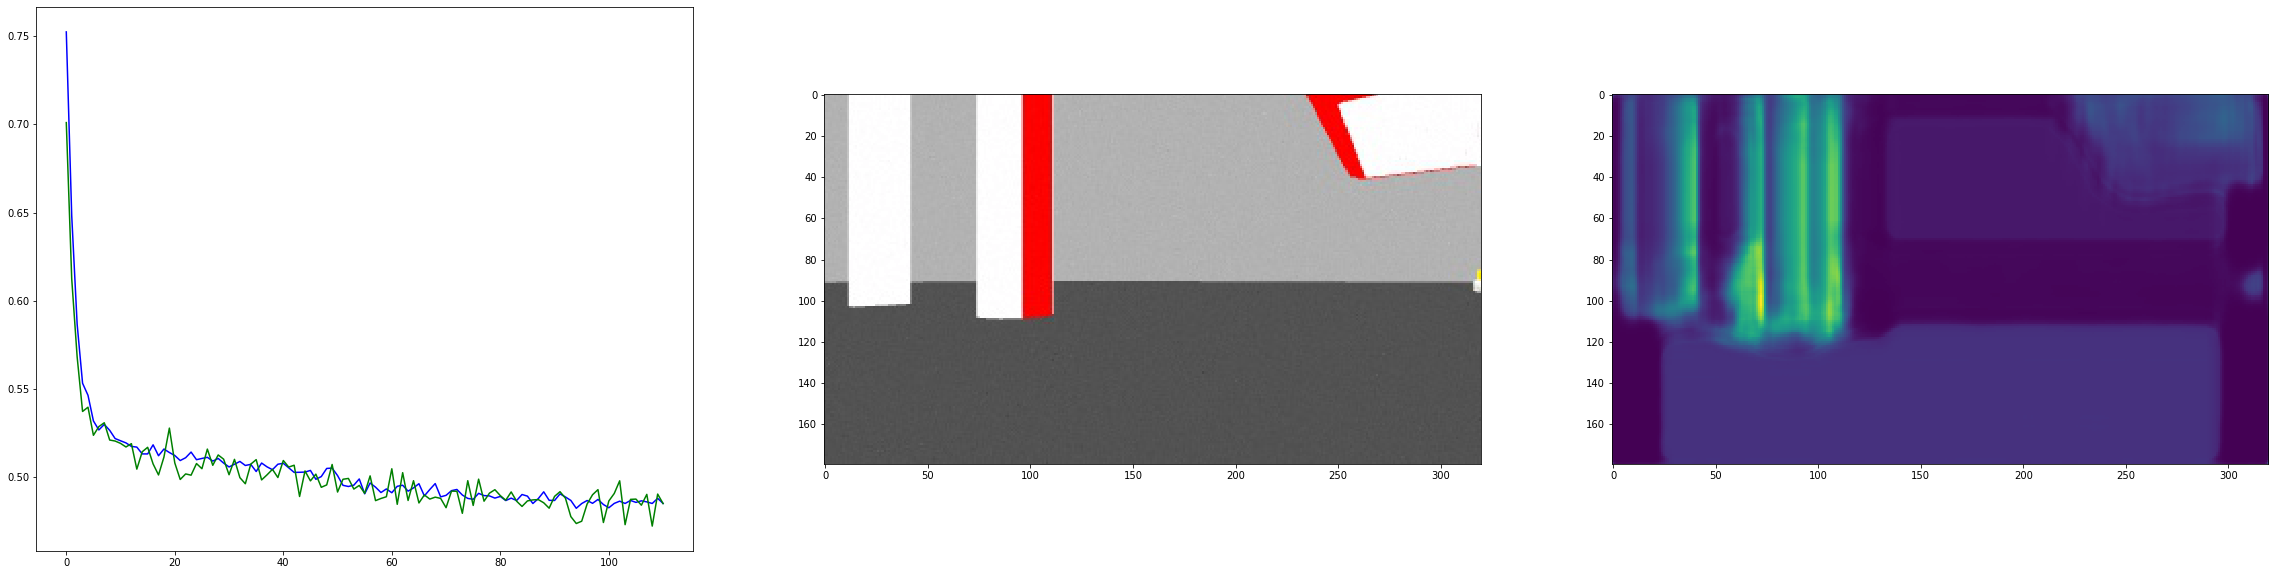

KeyboardInterrupt: 

In [274]:
from IPython.display import clear_output

num_epochs = 200
train_steps_per_epoch = 100
test_steps_per_epoch = 10
batch_size = 16

collision_buffer = 35
path_length = 30

# Make Model
navnet = NavNet(input_shape=(3, 180, 320)).to(device)
optimizer = torch.optim.Adam(navnet.parameters(), lr=1e-4)

train_batch_gen = batch_generator(train_data, batch_size=batch_size)
test_batch_gen = batch_generator(test_data, batch_size=batch_size)

train_loss = []
test_loss = []

for epoch in range(num_epochs):
        
    # Train
    avg_train_loss = 0
    navnet.train()
    for step in range(train_steps_per_epoch):
        optimizer.zero_grad()
        
        right_images, left_images = next(train_batch_gen)
        output = navnet(left_images.to(device))
        loss = navnet.loss(output, left_images.to(device), right_images.to(device))
        
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
        
    avg_train_loss /= train_steps_per_epoch
    train_loss.append(avg_train_loss)
    
    # Test
    avg_test_loss = 0
    disp_output = None
    disp_input = None
    navnet.eval()
    for step in range(test_steps_per_epoch):
        
        right_images, left_images = next(test_batch_gen)
        output = navnet(left_images.to(device))
        loss = navnet.loss(output, left_images.to(device), right_images.to(device))
        
        avg_test_loss += loss.item()
        
        # additional visualization ability
        disp_output = output
        disp_input = left_images
        
    avg_test_loss /= test_steps_per_epoch
    test_loss.append(avg_test_loss)
    
    
    
    # Plot the losses in realtime
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(40,10))
    fig.add_subplot(1,3,1)
    
    plt.plot(train_loss,  color='blue', label='train loss')
    plt.plot(test_loss,  color='green', label='test loss')

    fig.add_subplot(1,3,2)
    plt.imshow(utils.torch_image_to_cv_image(disp_input[0]))
    
    fig.add_subplot(1,3,3)
    plt.imshow(utils.torch_image_to_cv_image(disp_output[0,0].unsqueeze(0).cpu().detach()))
    
    plt.show()
    
print(train_loss)
print("#########")
print(test_loss)

## Visualize the model

In [277]:
import time, cv2
import numpy as np

scale = 5
crop_line = 90

focal_length = 190.68
baseline = 0.2

navnet.eval()
for i in range(1, len(test_data.data)):
    img = test_data.read_torch_image(i)
    if len(img) > 0:
        cv_image = utils.torch_image_to_cv_image(img)
        
        image = img.unsqueeze(0).to(device)
        model_output = navnet(image)

        depth_map = focal_length*baseline/((model_output[0,0]*320).cpu().detach().numpy())
        
        depth_map = np.clip(depth_map, 0, scale)/scale
        
        depth_img = cv2.applyColorMap((depth_map*255).astype('uint8'), cv2.COLORMAP_JET);
        display_image = cv2.addWeighted((cv_image*255).astype('uint8'),0.7,depth_img,0.3,0)  
        display_image = np.hstack((display_image, depth_img))
        
        cv2.imshow('image', cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
        cv2.waitKey(10)

## Save the model

In [278]:
# Standard pytorch model saving/loading
name = "navnet-depth-estimator"
torch.save(navnet.state_dict(), name + ".pt")
navnet.load_state_dict(torch.load(name + ".pt")) # test reloading model

<All keys matched successfully>